# *Authorship Attribution*

## *Untersuchung der Texte "von einem Clown" in der "Schaubühne"*

In [1]:
import os
import re
import math
from collections import Counter

import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("de_core_news_sm")

import sklearn.feature_extraction.text as sk_text
import sklearn.preprocessing as preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.decomposition
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.spatial.distance as scidist
import scipy.cluster.hierarchy as hierarchy

# 1. Einführung und Fragestellung

*Die Schaubühne* war eine Wochenzeitschrift, die 1905 vom Berliner Theaterkritiker Siegfried Jacobson gegründet wurde. War sie zuerst eine reine Theater- und Kulturzeitschrift, wurde sie 1918 in *Weltbühne* umbenannt und begann sich auch politischen Themen zu widmen. Die *Schaubühne* erschien wöchentlich und wurde jeweils in zwei Bänden pro Jahr im Umfang von etwa 700 Seiten zusammengefasst. Die Autoren der Artikel sind unterschiedlich, ein großer Teil von ihnen wurde vom Herausgeber Siegfried Jacobson selbst verfasst, daneben finden sich Artikel von prominenten Kritikern wie Julius Bab und Willi Handl, Gedichte, Auszüge aus Dramen und Gastbeiträge von Schauspieler\*innen, KünstlerInnen, anderen Theaterkritiker\*innen und Personen aus der Theaterszene der ersten Hälfte des 20. Jahrhunderts (Austrian Academy of Sciences 2022). 

Einige dieser Artikel wurde aus unterschiedlichen Gründen unter Pseudonymen verfasst, einer davon ist schlichtweg, dass nicht immer wieder dieselben Namen jener Autor\*innen, die die meisten Artikel schreiben, unter den jeweiligen Texten erscheinen. Die drei Artikel „von einem Clown“ aus den Jahren 1908 bis 1910, deren AutorIn in dieser Arbeit herausgefunden werden soll, befassen sich mit den prekären Arbeitsbedingungen für Schauspieler\*innen an deutschsprachigen Theatern und der anonyme Autor gibt Insiderinformationen, die ihn gewissermaßen zum Whistleblower machen. In diesem Fall scheint das Pseudonym „Clown“ vor allem zum Schutz des Autors verwendet werden. 

Die Texte des Clowns bieten sich für die Fallstudie an, da mit drei Artikeln ausreichend Tokens vorliegen und sich die potenziellen Kandidaten durch den Hinweis von Projektleiterin Dr. Imelda Rohrbacher, die an der digitalen Edition der *Schaubühne* arbeitet, dass der „Clown“ Schauspieler war, zumindest etwas einschränken lassen. 

Grundvoraussetzung für ein Ergebnis der Studie ist, dass der „Clown“ auch unter Klarnamen zumindest einmal in der *Schaubühne* publiziert hat und damit in die Liste der potenziellen Kandidat\*innen aufgenommen wird. Es ist nicht auszuschließen, dass der „Clown“ nie unter Klarnamen in der Schaubühne publiziert hat und daher nicht berücksichtig werden konnte, da es faktisch unmöglich wäre, zusätzlich ein Referenzkorpus von Schauspieler\*innen, die in der Zeit um 1910 an deutschen Bühnen aktiv waren, aber *nicht* in der *Schaubühne* publiziert haben, zu erstellen. 

Von allen SchauspielerInnen, die in der Schaubühne einige Jahre vor und nach Erscheinen der Clown-Texte publiziert haben, konnten sich leider auch nicht genug Referenztexte finden lassen und sie können aufgrund dessen in großen Teilen der Untersuchung nicht berücksichtigt werden. Andererseits ist vielleicht anzunehmen, dass eine Person, die *ausschließlich* Schauspieler\*in war und sich ansonsten in ihrem gesamten Leben nicht unter Klarnamen schriftstellerisch betätigt hat, auch nicht AutorIn der drei längeren Artikel über einen Zeitraum von drei Jahren hinweg war. 

Tatsächlich kristallisierten sich unter den Autoren, von denen genug Tokens vorliegen, zwei Kandidaten heraus, die als „Clown“ in Frage kommen. Am Ende erscheint der Schauspieler, Regisseur und Dramaturg Otto Kienscherf als der wahrscheinlichste Autor der „Clown“-Texte. 



# 2. Datengrundlage

Das digitale Editionsprojekt des Austrian Centre for Digital Humanities an der Österreichischen Akademie der Wissenschaften umfasst Annotation der Digitalisate der Schaubühne, Registererstellung, Verknüpfung mit Normdatensätzen, technische Einrichtung und open access-Publikation (ÖAW 2022). Das Projekt läuft seit weniger als zwei Jahren und die Daten sind online noch nicht verfügbar, aufgrund meines Praktikums am ACDH CH verfüge ich aber über frühe Versionen der Digitalisate der Bände 2.1 bis 8.2 (von 1906 bis 1913) im XML-Format. Die Annotationen in diesen Bänden sind noch nicht standardisiert, was aber keine Rolle spielt, da das Markup ohnehin entfernt wird und für diese Untersuchung nur der reine Text behalten wird. 

Die Korpora wurden hauptsächlich aus Texten dieser Bände der *Schaubühne* zusammengestellt. Wenn dort nur zu wenig Text für einen Autor zu finden ist, wurden die Referenzkorpora, wenn möglich, durch Publikationen der jeweiligen Autoren außerhalb der *Schaubühne* erweitert. Die Referenzkorpora für die beiden Autoren Max Martersteig und Otto Kienscherf, die sich als am wahrscheinlichsten herausgestellt haben, wurden zusätzlich durch mehrere Texte erweitert, um den Vergleich mit einer größeren Textmenge zu ermöglichen.

## 2.1 Einlesen der Daten

### 2.1.1 Einlesen der Clown-Texte

Folgende Texte publizierte der anonyme Autor, aufgeteilt auf mehrere Ausgaben, unter dem Pseudonym „Clown“:

-	„Moderne Sklaven“ in Band 3.1
-	„Menschenhandel“ in Band 4.1
-	„Theatertrust“ in Band 4.2

Die drei Texte prangern Missstände an Theatern im deutschsprachigen Raum an und befassen sich mit der rechtlichen Situation für dort angestellte Personen. 

Die Texte werden hier inklusive Markup eingelesen und werden als Values einem Dicitionary angefügt, Keys sind die Namen der Textfiles, in denen die Texte gespeichert wurden (zusammegesetzt aus "Clown", Bandnummer, Textitel).

In [2]:
path_corpus = "Korpora"
clown_texts = ["Clown_4_1_Menschenhandel.txt", "Clown_4_2_Theatertrust.txt", "Clown_3_1_Moderne_Sklaven.txt"]
clown = {}

for text in clown_texts:
    file_path=os.path.join(path_corpus, text)
    with open(file_path, "r", encoding="utf8") as f:
        clown_text = f.read()
        clown[text] = clown_text
    

### 2.1.2 Einlesen der Referenztexte

18 Personen qualifizierten sich nach umfangreicher Recherche als Urheber der "Clown"-Texte. Die meisten von ihnen sind Schauspieler, da in einer früheren Ausgabe der *Schaubühne* die Clown-Serie mit dem Hinweis, dass die Texte von einem Schauspieler stammen würden, angekündigt wurde. Zusätzlich wurden Richard Treitel und Julius Bab, die Theaterkritiker und keine Schauspieler waren, zu den Referenzkorpora hinzugefügt, da sie viele Artikel, auch unter aufgelösten Pseudonymen, für die *Schaubühne* verfasst haben und sich auch ähnlichen Themen widmen. Die Liste der Schauspieler, die hier als potenzielle Kandidaten genauer untersucht werden, wurde auf Basis der Bände 3.1 bis 8.2 erstellt: grundsätzlich kamen alle Schauspieler, die in diesen Bänden einen Text veröffentlicht haben, in Frage, eingeschränkt wurde diese Anzahl dann noch durch Hinweise von Projektleiterin Dr. Imelda Rohrbacher, die aufgrund ihrer Expertise bestimmte Personen als Autor ausschließen konnte, und durch weitere Recherche zum Hintergrund der potenziellen Kandidaten (Personen, die *ausschließlich* Texte zu gänzlich anderen Themen als allem, was in die juristische oder soziale Richtung geht, publiziert oder sich nur in anderem Genre, wie z.B. Drama, bewegt haben, wurden damit ausgeschlossen) eingeschränkt. 

Ziel war, in den mir verfügbaren Bänden der *Schaubühne* zumindest Referenztexte im Umfang von 2000 Tokens zu finden. War dies nicht möglich, wurden, wenn möglich, die Referenzkorpora durch externe Quellen erweitert, um zumindest 2000 Tokens zu erreichen. Für Max Martersteig und Otto Kienscherf, die sich als die wahrscheinlichsten Autorenkandidaten herausgestellt haben, wurden noch mehr Referenztexte hinzugefügt. All diese Texte werden hier eingelesen und in einem Dictionary gespeichert, Keys sind jeweils die Namen der Autoren (abgespeichert zuerst in Ordnern, benannt mit Vorname_Nachname der Autoren, die Textfiles benannt mit Nachname, ggf. Band, wenn in der *Schaubühne* publiziert, und bis zu 4 Wörtern des Texttitels). 


*(__Anmerkung:__ Der relative Pfad funktioniert hier nicht, was mir leider absolut unerklärlich ist und wofür ich keine Lösung finden konnte. Für "directory" bitte den absoluten Pfad einsetzen.)*

In [3]:
directory = ""
authors = [name for name in os.listdir(directory)] # alle Texte sind in nach den Autoren benannten Ordnern gespeichert, ihre Namen werden in einer Liste gespeichert
reference = {}

for author in authors: 
    path=os.path.join(directory, author) # Pfad zu den Ordnen für die einzelnen Schauspieler
    for filename in os.scandir(path): # iterieren über alle Objekte (als os.DirEntry-Objekte) in den Unterordnern
        if not filename.name.endswith('.txt'): # wenn der Name des Files NICHT auf ".txt" endet ...
            continue # ... endet die Iteration und die nächste beginnt
        file_path = os.path.join(path, filename) # Pfad zu allen Files in den Unterordnern
        if author not in reference.keys(): # wenn es noch keinen Eintrag zum Autor im Reference-Dict gibt, 
            reference[author] = "" # wird hier einer erstellt
        with open(file_path, "r", encoding="utf8") as f: # die Textdatei wird geöffnet
            text = f.read()
            reference[author] += text # und ihr Text dem jeweiligen Autor angefügt

## 2.2 Preprocessing

### 2.2.1 Allgemeine Vorbereitung der Texte und Referenztexte

Im nächsten Schritt werden die Korpora in eine Form gebracht, mit der sie weiterverarbeitet werden können. 

Zuerst werden die Schreibweisen der Texte vereinheitlicht. Im Frakturdruck werden am Wortbeginn in der Schaubühne und auch einigen anderen Quellen der Referenztexte große J statt I verwendet. Um dies zu vereinheitlichen und auch großgeschreibene und klein geschriebene Wörter vergleichbar zu machen, werden in allen häufigen Wörtern, die eventuell in die Liste der most frequent words aufgenommen werden könnten, diese großen J durch I ersetzt. Auch alle scharfen ß werden durch ss ersetzt, damit hier mögliche verschiedene Schreibweisen kein Problem darstellen. Die Schreibweise *giebt* wird zu *gibt* vereinheitlicht. 

Als wichtigster Schritt im Preprocessing wird das gesamte Markup der XML-Dateien entfernt. 

Danach werden die Texte tokenisiert und mit SpaCy lemmatisiert.

In [4]:
# Dictionary mit häufigen Wörtern, die mit großem J statt I beginnen (können)

j_to_i = {"Jm": "im", "Jch": "ich", "Jnnern": "innern", "Jndien": "Indien", "Jnszenierung": "Inszenierung", "Jn": "in", "Jdeal": "Ideal", "Jmpression": "Impression", "Jhr": "Ihr", "Jdee": "Idee", "Jllusion": "Illusion", "Jst": "ist", "Jhnen": "ihnen"}

In [5]:
def preprocess(corpus):
    
    for text in corpus:
        
        # Ersetzen der Js durch Is im Fraktur-Digitalisat
        for j, i in j_to_i.items():
            corpus[text] = re.sub(j, i, corpus[text])
            
        # Entfernen der Tags und Standardisierung
        corpus[text] = re.sub(r'<TITLE>.*</TITLE>', '', corpus[text], count=0) # Entfernen der Texttitel
        corpus[text] = re.sub(r'<TITLEPART.*</TITLEPART>', '', corpus[text], count=0) # Entfernen der Texttitel
        corpus[text] = re.sub(r'\n<lb break="no"/>', '', corpus[text]) # Zusammenfügen abgeteilter Wörter
        corpus[text] = re.sub(r'<lb/>', ' ', corpus[text]) # Ersetzen der Line-Beginnings durch ein Leerzeichen
        corpus[text] = re.sub(r'<fw.*</fw>', '', corpus[text]) # Entfernen der Seitenzahlen
        corpus[text] = re.sub(r'ß', 'ss', corpus[text]) # Ersetzen aller scharfen ß
        corpus[text] = re.sub(r'giebt', 'gibt', corpus[text]) # Ersetzen von giebt mit gibt für Vereinheitlichung
        corpus[text] = re.sub(r'<.*?>', '', corpus[text]) # Entfernen aller übrigen Tags
    
    # Tokenisieren
    corpus_tokenized = {}
    for text in corpus: 
        tokens = word_tokenize(corpus[text])
        text_tokenized = [token.lower() for token in tokens if token not in "./\_*(),;:!“„?—‘...——.–=§"]
        corpus_tokenized[text] = text_tokenized
    
    # Lemmatisieren
    corpus_lemmatized = {}
    for text in corpus_tokenized:
        doc = nlp(" ".join(corpus_tokenized[text]))
        text_lemmatized = [token.lemma_ for token in doc]
        corpus_lemmatized[text] = text_lemmatized
        
    return corpus_lemmatized

In [6]:
corpus_clown = preprocess(clown)
reference_corpus = preprocess(reference)

**Es liegen jetzt Referenztexte und die Texte des "Clowns" in folgendem Umfang zur weiteren Untersuchung vor:**

In [7]:
for author, text in reference_corpus.items():
    print(f"{author}: {len(text)} Tokens")

Adolf_Winds: 4635 Tokens
Albert_Boree: 2305 Tokens
Alfred_Auerbach: 2787 Tokens
Alfred_Halm: 1929 Tokens
Egon_Friedell: 13379 Tokens
Ernst_Clefeld: 2741 Tokens
Franz_Blei: 2836 Tokens
Franz_Kreidemann: 1804 Tokens
Franz_Vallentin: 2258 Tokens
Hanns_Hannsen: 4105 Tokens
Hans_Olden: 4465 Tokens
Julius_Bab: 4427 Tokens
Max_Martersteig: 12987 Tokens
Max_Pategg: 1589 Tokens
Oscar_Sauer: 242 Tokens
Otto_Kienscherf: 11118 Tokens
Richard_Treitel: 5931 Tokens
Rudolf_Bluemner: 2043 Tokens


In [8]:
for title, text in corpus_clown.items():
    text_title = title.split(".")[0]
    print(f"{text_title}: {len(text)}")

Clown_4_1_Menschenhandel: 4708
Clown_4_2_Theatertrust: 1641
Clown_3_1_Moderne_Sklaven: 13683


### 2.2.2 Splitten des Clown-Corpus in Chunks

Für die Untersuchung werden zu Beginn Chunks von je 2000 Tokens verwendet. Die Länge bietet sich an, da für die meisten Autorenkandidaten, wie oben ersichtlich, zumindset ca. 2000 verfügbar sind.

Damit der gesamte verfügbare Text des "Clowns" verwendet werden kann und nicht nur jeweils die ersten 2000 Tokens, wie das bei den Referenztexten gemacht wird, werden die drei Texte des Clowns in mehrere Chunks von jeweils 2000 Tokens gesplittet. Der zweite, etwas kürzere Text, muss leider in dieser Länge beibehalten werden.

In [9]:
chunk_size = 2000

clown_chunks = []

for text in corpus_clown.values():
    
    chunk_start = 0
    chunk_end = chunk_size
    
    if len(text) <= chunk_size: # Texte mit einer geringeren Länge als 2000 Tokens werden behalten
        clown_chunks.append(text)
        
    else:
    
        while chunk_end <= len(text):
            clown_chunks.append(text[chunk_start:chunk_end]) #von längeren Texten werden die Tokens 0 bis 1999 genommen
            chunk_start += chunk_size # danach werden die Tokens erhöht auf 2000 bis 3999 etc.
            chunk_end += chunk_size # solange, bis das Ende des Chunks höher wäre als der Text überhaupt Tokens hat

        
print(f"Insgesamt können die Texte des anonymen Autors in {len(clown_chunks)} Chunks mit einer Länge von maximal {chunk_size} Tokens gesplittet werden.")

Insgesamt können die Texte des anonymen Autors in 9 Chunks mit einer Länge von maximal 2000 Tokens gesplittet werden.


Für die weitere Verarbeitung müssen die Texte, die momentan noch in Listenform vorliegen, in Strings umgewandelt werden. 

Für eine besserer Darstellung der Ergebnisse werden diese Strings durchnummeriert. In einer separaten Liste werden ihre Bezeichnungen ("C" + eine Nummer) abgespeichert.

In [10]:
clown_chunks = [" ".join(chunk) for chunk in clown_chunks]
clown_names = [f"C{n+1}" for n in range (len(clown_chunks))]

In [11]:
for name, chunk in zip(clown_names, clown_chunks):
    print(f"{name}: {len(chunk.split(' '))}")

C1: 2000
C2: 2000
C3: 1641
C4: 2000
C5: 2000
C6: 2000
C7: 2000
C8: 2000
C9: 2000


### 2.2.3 Kürzen der Referenztexte

Von den Referenztexten werden jeweils die ersten 2000 Tokens genommen und als Liste in einem Dictionary abgespeichert, dessen Keys die Namen der Autoren sind.

In [12]:
def shorten_corpus(corpus):

    corpus_shortened = {}
    for k, v in corpus.items():
        corpus_shortened[k] = v[:2000]

    return(corpus_shortened)

reference_shortened = shorten_corpus(reference_corpus)

for k, v in reference_shortened.items():
    print(f"{k}: {len(v)} Tokens")

Adolf_Winds: 2000 Tokens
Albert_Boree: 2000 Tokens
Alfred_Auerbach: 2000 Tokens
Alfred_Halm: 1929 Tokens
Egon_Friedell: 2000 Tokens
Ernst_Clefeld: 2000 Tokens
Franz_Blei: 2000 Tokens
Franz_Kreidemann: 1804 Tokens
Franz_Vallentin: 2000 Tokens
Hanns_Hannsen: 2000 Tokens
Hans_Olden: 2000 Tokens
Julius_Bab: 2000 Tokens
Max_Martersteig: 2000 Tokens
Max_Pategg: 1589 Tokens
Oscar_Sauer: 242 Tokens
Otto_Kienscherf: 2000 Tokens
Richard_Treitel: 2000 Tokens
Rudolf_Bluemner: 2000 Tokens


**Entfernen aller zu kurzen und damit nicht vergleichbaren Texte**

Alle Texte mit unter 1800 Tokens werden aussortiert. Auf diese Weise bleibt Franz Kreidemann im Korpus und ist zwar etwas kürzer als 2000 Tokens, Max Pategg und Oscar Sauer können leider nicht weiter überprüft werden und werden erst im nächsten Schritt mit den N-Grammen miteinbezogen.

In [13]:
def remove_less_then_1800_tokens(corpus):

    corpus_1800 = {}
    
    for author, text in corpus.items():
        if len(text) >= 1800: # nur wenn ein Text mindestens 1800 Tokens hat ...
            corpus_1800[author] = text # ... wird er dem neuen Dictionary hinzugefügt
        
    return corpus_1800

reference_shortened = remove_less_then_1800_tokens(reference_shortened)

for k, v in reference_shortened.items():
    print(f"{k}: {len(v)} Tokens")

Adolf_Winds: 2000 Tokens
Albert_Boree: 2000 Tokens
Alfred_Auerbach: 2000 Tokens
Alfred_Halm: 1929 Tokens
Egon_Friedell: 2000 Tokens
Ernst_Clefeld: 2000 Tokens
Franz_Blei: 2000 Tokens
Franz_Kreidemann: 1804 Tokens
Franz_Vallentin: 2000 Tokens
Hanns_Hannsen: 2000 Tokens
Hans_Olden: 2000 Tokens
Julius_Bab: 2000 Tokens
Max_Martersteig: 2000 Tokens
Otto_Kienscherf: 2000 Tokens
Richard_Treitel: 2000 Tokens
Rudolf_Bluemner: 2000 Tokens


Damit die Referenztexte weiterverarbeitet werden können, müssen sie wie die Texte des Clowns in einer Liste von Strings abgespeichert werden.

In [14]:
authors = [author for author in reference_shortened.keys()]
documents = [" ".join(text) for text in reference_shortened.values()]

## 2.3 Erstellen des Vokabulars

Für die Authorship Attribution werden nur die ca. 50 bis 100 häufigsten Funktionswörter des gesuchten Autors mit den Worthäufigkeiten der Autorenkandidaten vergleichen. Diese werden in Listen mit unterschiedlich vielen häufigsten Wörter abgespeichert, sodass diese Listen später als Parameter verwendet werden können und genauer betrachtet werden kann, welche Vokabulargröße in diesem konkreten Fall zu den besten Ergebnissen führt. Es werden dafür die häufigsten Wörter der gesamten drei Clown-Texte gezählt. Bedeutungstragende Wörter, die nur typisch für die drei vom "Clown" vorliegenden Texte sind, werden mit *#* gekennzeichnet und später nicht im Vokabular berücksichtigt.

Auswahl der Most Frequent Words:

In [15]:
number_of_mfw = 50
#number_of_mfw = 75
#number_of_mfw = 100

word_count = Counter([word for article in corpus_clown.values() for word in article if word not in "=."]) # Zählen der Wörter ALLER Clown-Texte
mfws = [word for word, count in word_count.most_common(number_of_mfw)] # die number_of_mfw-häufigsten Wörter werden einer Liste hinzugefügt

Abspeichern der Wörter in einem txt-File:

In [16]:
with open ("mfws_clown.txt", "w") as f: 
    for word in mfws: 
        f.write("%s\n" % word)

Funktion zum Einlesen aller Wörter, die nicht mit *#* gekennzeichnet sind:

In [17]:
def load_vocab(file):
    vocab = [l.strip() for l in open(file) if not l.startswith('#') and l.strip()]
    return vocab

Abspeichern des entsprechenden Vokabulars in einer Liste:

In [18]:
vocab_50 = load_vocab("mfws_clown_50.txt")
vocab_75 = load_vocab("mfws_clown_75.txt")
vocab_100 = load_vocab("mfws_clown_100.txt")

print(len(vocab_50), len(vocab_75), len(vocab_100))
print(vocab_50[:10])

47 68 83
['der', 'ich', 'und', 'sich', 'sein', 'einen', 'zu', 'in', 'mein', 'dies']


## 2.4 Vektorisieren, Normalisieren und Skalieren der Korpora

Folgende Funktion hat die Referenztexte, die Clown-Texte und das Vokabular in einer bestimmten Größe als Parameter. Im ersten Schritt werden die Texte vektorisiert. Der CountVectorizer erstellt die Document-Term-Matrix für die Referenztexte auf Basis des angegebenen Vokabulars. Output ist ein Array mit der Größe Anzahl Dokumente x Vokabular, in dem die absoluten Häufigkeiten jedes Worts im Vokabular für jedes Dokument gespeichert sind. Danach werden die Werte nach L1-Norm normalisiert. L1 verändert die Werte so, dass die Summe aller Werte für ein Dokument 1 ergibt. Mit dem Scaler im dritten Schritt werden die Z-Scores ermittelt. Z-Scores geben die Entfernung eines Werts vom Mittelpunkt an und berechnen sich durch die Standardabweichung. 

In [19]:
def preprocess_corpus(reference_documents, unknown_documents, vocab_size):
    
    # Vektorisieren
    vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab_size)
    v_documents = vectorizer.fit_transform(reference_documents).toarray()
    v_unknown = vectorizer.transform(unknown_documents).toarray()
    
    # Normalisieren nach L1-Norm
    p_documents = preprocessing.normalize(v_documents.astype(float), norm='l1')
    p_unknown = preprocessing.normalize(v_unknown.astype(float), norm='l1')
    
    # Berechnen Z-Scores
    scaler = preprocessing.StandardScaler()
    s_reference = scaler.fit_transform(p_documents)
    s_clown = scaler.transform(p_unknown)
    
    return s_reference, s_clown

# 3. Untersuchung

## 3.1 Methoden

Es wurden alle drei im Kurs behandelten Methoden Burrows Delta (mit Tokens und Character-N-Grammen), HAC und PCA angewandt. PCA und HAC stellten sich als schwer zu interpretieren und für diesen konkreten Fall eher unbrauchbar heraus, da auch mit Anpassung der Parameter zu keinen Ergebnissen führen und nicht einmal die Texte des „Clowns“ mit sich selbst clustern. Auch die Delta-Variante, für die Character-N-Gramms anstatt Tokens verwendet werden, ist problematisch. Ziel dieses Ansatzes war, auch jene Autoren, von denen nur wenige Tokens vorliegen, berücksichtigen zu können. Die Ergebnisse sind nicht aussagekräftig und stehen teilweise sogar in Widerspruch zu den Ergebnissen von Delta mit Tokens. Burrows Delta mit Tokens dagegen ermöglicht immerhin eine Eingrenzung der potenziellen Kandidaten und deutet darauf hin, dass Otto Kienscherf hinter dem „Clown“ steckt, auf den die anderen Methoden nicht vermuten lassen. 

## 3.2. Burrows Delta

Burrows Delta ermittelt die Distanz zwischen einem Text (in diesem Fall jedem der Texte des „Clowns“) und einem Referenztext (die Texte der bekannten Autoren). Dafür wird aus den normalisierten Dokumentvektoren, basierend auf den most frequent words, die in der Funktion oben erstellt wurden, im vieldimensionalen Raum mittels euklidischer Distanz, Cosinus oder Cityblock/Manhattan-Distanz oder Abstand gemessen. Der Autor jenes Dokuments mit dem geringsten Abstand wird als wahrscheinlichster Autor für das Dokument unbekannten Autors vorhergesagt (Evert et al. 2017). Dem Ansatz liegt die Theorie zugrunde, dass der Gebrauch von nicht-bedeutungstragenden Funktionswörtern für einen bestimmten Autor über mehrere Texte hinweg konstant ist. Welche der Metriken verwendet wird sowie auch das verwendete Vokabular haben großen Einfluss auf die Ergebnisse. 

Die Funktion berechnet, falls diese nicht bereits zuvor berechnet wurden, die Z-Scores. Danach werden die Distanzen berechnet und das Dokument mit der geringsten Distanz wird ausgegeben. 

In [20]:
class Delta:
    """Delta-Based Authorship Attributer."""

    def fit(self, X, y):
        """Fit (or train) the attributer.

        Arguments:
            X: a two-dimensional array of size NxV, where N represents
               the number of training documents, and V represents the
               number of features used.
            y: a list (or NumPy array) consisting of the observed author
                for each document in X.

        Returns:
            Delta: A trained (fitted) instance of Delta.

        """
        self.train_y = np.array(y)
        self.scaler = preprocessing.StandardScaler(with_mean=False)
        self.train_X = self.scaler.fit_transform(X)

        return self

    def predict(self, X, metric='cityblock'):
        """Predict the authorship for each document in X.

        Arguments:
            X: a two-dimensional (sparse) matrix of size NxV, where N
               represents the number of test documents, and V represents
               the number of features used during the fitting stage of
               the attributer.
            metric (str, optional): the metric used for computing
               distances between documents. Defaults to 'cityblock'.

        Returns:
            ndarray: the predicted author for each document in X.

        """
        X = self.scaler.transform(X)
        dists = scidist.cdist(X, self.train_X, metric=metric)
        return self.train_y[np.argmin(dists, axis=1)]

### 3.2.1 Burrows Delta mit Tokens

Folgende Funktion gibt die **Vorhersage für jeden Clown-Chunk für jede Metrik** aus. 

Parameter:

- Chunks der Referenztexte, die verwendet werden sollen
- Clown_Texte, die verwendet werden sollen
- Die in Frage kommenden Kandidaten in Form einer Liste
- Das entsprechende Vokabular
- Die Namen der Clown-Texte, mit denen die Zeilen im Df benannt werden

In [21]:
metrics_names = ["cityblock", "cosine", "euclidean"]

In [22]:
def delta_predictions(reference_corpus, unknown_corpus, authors, vocab_size, row_names):
    
    delta_results = {}
    
    # Dokumente werden mit dem entsprechenden Vokabular vektorisiert und skaliert
    s_reference, s_clown = preprocess_corpus(reference_corpus, unknown_corpus, vocab_size)
    
    # Delta Classifier wird instantiiert
    delta = Delta()  
    
    # für jede Metrik wird für jeden Chunk des "Clowns" eine Vorhersage gemacht
    for m in metrics_names:
        
        delta.fit(s_reference, authors)   # Delta Classifier wird gefitted
        preds = delta.predict(s_clown, metric=m) 
        delta_results[m] = list(preds)
        
   # die Vorhersagen werden in einem Df abgespeichert
    delta_results_df = pd.DataFrame(data=delta_results)
    delta_results_df.index = row_names
    delta_results_df
    
    return delta_results_df

**Vorhersage für alle Chunks von 2000 Tokens für jede Metrik**

Zuerst wird die Funktion auf die Chunks von je 2000 Tokens, die oben erstellt wurden, angewandt. (Zu berücksichtigen hier ist hier, dass Chunk 3 vom "Clown" etwas kürzer als 2000 Tokens ist!)

In [23]:
delta_predictions_df = delta_predictions(documents, clown_chunks, authors, vocab_75, clown_names)
delta_predictions_df

,cityblock,cosine,euclidean
C1,Franz_Kreidemann,Franz_Kreidemann,Franz_Kreidemann
C2,Ernst_Clefeld,Ernst_Clefeld,Ernst_Clefeld
C3,Otto_Kienscherf,Otto_Kienscherf,Otto_Kienscherf
C4,Hanns_Hannsen,Richard_Treitel,Max_Martersteig
C5,Hanns_Hannsen,Richard_Treitel,Hanns_Hannsen
C6,Alfred_Halm,Franz_Vallentin,Alfred_Auerbach
C7,Otto_Kienscherf,Alfred_Halm,Otto_Kienscherf
C8,Hanns_Hannsen,Albert_Boree,Albert_Boree
C9,Hanns_Hannsen,Alfred_Halm,Alfred_Auerbach


In [24]:
print(f"In Frage kamen bisher {len(authors)} Autorenkandidaten.")

In Frage kamen bisher 16 Autorenkandidaten.


Die Anzahl der möglichen Kandidaten wird damit immerhin ziemlich eingeschränkt! Kandidaten, die bei verschiedenem Vokabular nur sehr wenig vorausgesagt werden, können ausgeschieden werden. In Frage scheinen damit noch zu kommen: Kreidemann, Clefeld, Kienscherf, Martersteig, Treitel, Halm, Hannsen

Die weiteren Untersuchungen sollen sich auf diese 7 Kandidaten in der engeren Auswahl beschränken, um herauszufinden, ob sich einer oder mehrere von ihnen noch als wahrscheinlicher herausstellen.

**Vergleich der durchschnittlichen Distanz der wahrscheinlichsten Autoren**

Diese Funktion berechnet die durchschnittliche Distanz pro Metrik aller 9 Clown-Chunks zu diesen 7 Autoren in der engeren Auswahl. Die folgende Funktion ist in dieser Schreibweise relativ lang, weil der Übersichtlichkeit halber die Abstände für jede Metrik einzeln berechnet werden (ginge alternativ auch in einem Loop).

In [25]:
authors_reduced = ("Franz_Kreidemann", "Otto_Kienscherf", "Max_Martersteig", "Ernst_Clefeld", "Richard_Treitel", "Alfred_Halm", "Hanns_Hannsen")

In [26]:
def calculate_avg_distances(vocab_size):

    # Dokumente werden mit dem entsprechenden Vokabular vektorisiert und skaliert
    s_reference, s_clown = preprocess_corpus(documents, clown_chunks, vocab_size)

    # Distanzen mit Cityblock werden berechnet und einem Dict angefügt
    sum_distances = {}
    for c, doc_name in zip(s_clown, clown_names):
        distances = [ scidist.cityblock(c, doc) for doc in s_reference]

        for distance, author in zip(distances, authors):
            if author in authors_reduced:
                if author not in sum_distances.keys(): 
                    sum_distances[author] = distance
                else: 
                    sum_distances[author] += distance
                                    
    avg_distances_cb = {}

    for author, distance in sum_distances.items():
        avg_distance = distance/len(clown_names)
        avg_distances_cb[author] = avg_distance

    
    # Distanzen mit Cosinus werden berechnet und einem Dict angefügt
    sum_distances = {}

    for c, doc_name in zip(s_clown, clown_names):
        distances = [ scidist.cosine(c, doc) for doc in s_reference]

        for distance, author in zip(distances, authors):
            if author in authors_reduced:
                if author not in sum_distances.keys(): 
                    sum_distances[author] = distance
                else: 
                    sum_distances[author] += distance

    avg_distances_cs = {}

    for author, distance in sum_distances.items():
        avg_distance = distance/len(clown_names)
        avg_distances_cs[author] = avg_distance
                    
    
    # Euklidische Distanzen werden berechnet und einem Dict angefügt
    sum_distances = {}

    for c, doc_name in zip(s_clown, clown_names):
        distances = [ scidist.euclidean(c, doc) for doc in s_reference]

        for distance, author in zip(distances, authors):
            if author in authors_reduced:
                if author not in sum_distances.keys(): 
                    sum_distances[author] = distance
                else: 
                    sum_distances[author] += distance

    avg_distances_ed = {}

    for author, distance in sum_distances.items():
        avg_distance = distance/len(clown_names)
        avg_distances_ed[author] = avg_distance
        
        
    # Die durchschnittliche Distanz für jede Metrik wird berechnet
    avg_distances = {}

    for author in avg_distances_cb.keys():
        avg_distances[author] = []
        avg_distances[author].append(avg_distances_cb[author])
        avg_distances[author].append(avg_distances_cs[author])
        avg_distances[author].append(avg_distances_ed[author])
    
        
    # Ausgabe in Form eines DF
    distances_df = pd.DataFrame(data=avg_distances)
    distances_df.index = metrics_names
    return distances_df

In [27]:
calculate_avg_distances(vocab_50)

,Alfred_Halm,Ernst_Clefeld,Franz_Kreidemann,Hanns_Hannsen,Max_Martersteig,Otto_Kienscherf,Richard_Treitel
cityblock,55.285150,61.163589,58.854552,58.187146,61.206541,52.659890,58.146782
cosine,0.857761,0.942606,0.957902,0.910097,1.084253,0.952765,1.003292
euclidean,10.788628,11.561428,11.147931,11.134282,11.508061,10.218258,11.219693


In [28]:
calculate_avg_distances(vocab_100)

,Alfred_Halm,Ernst_Clefeld,Franz_Kreidemann,Hanns_Hannsen,Max_Martersteig,Otto_Kienscherf,Richard_Treitel
cityblock,99.463236,110.402730,98.565690,103.020016,103.796473,93.953258,104.201026
cosine,0.896989,0.990478,0.980553,0.961032,1.054432,0.943190,0.992762
euclidean,14.483628,15.799202,14.296343,15.070170,14.680472,13.801650,15.153937


**Anmerkung:** Ein kleineres Vokabular führt zu insgesamt niedrigeren Distanzen, aber damit nicht automatisch besseren Ergebnissen.

**Ergebnisse der durchschnittlichen Distanzen für die 7 wahrscheinlichsten Autoren**:

Die Vokabulargröße scheint auf die durchschnittlichen Distanzen aller Chunks keinen besonders großen Einfluss zu haben. Cityblock tendiert immer zu Martersteig und Kienscherf, Kosinus zu Halm und Kienscherf, euklidische Distanz zu Martersteig und Kienscherf. 

**Vorhersage für die drei wahrscheinlichsten Kandidaten**

Von den sieben übrigen Kandidaten schaffen es damit drei in die noch engere Auswahl. Im Folgenden werden nur Texte dieser 3 Autoren mit dem Clown verglichen.

In [29]:
candidates = ["Otto_Kienscherf", "Max_Martersteig", "Alfred_Halm"]

In [30]:
reference_reduced = {}
for candidate in candidates: 
    reference_reduced[candidate] = reference_shortened[candidate]

documents_reduced = [" ".join(text) for text in reference_reduced.values()]

In [31]:
delta_predictions(documents_reduced, clown_chunks, candidates, vocab_75, clown_names)

,cityblock,cosine,euclidean
C1,Alfred_Halm,Max_Martersteig,Max_Martersteig
C2,Max_Martersteig,Max_Martersteig,Max_Martersteig
C3,Otto_Kienscherf,Otto_Kienscherf,Otto_Kienscherf
C4,Max_Martersteig,Max_Martersteig,Max_Martersteig
C5,Alfred_Halm,Otto_Kienscherf,Otto_Kienscherf
C6,Alfred_Halm,Otto_Kienscherf,Otto_Kienscherf
C7,Otto_Kienscherf,Otto_Kienscherf,Otto_Kienscherf
C8,Otto_Kienscherf,Otto_Kienscherf,Otto_Kienscherf
C9,Otto_Kienscherf,Otto_Kienscherf,Otto_Kienscherf


Halm wird nur sehr wenig vorhergesagt und ist damit wohl auch eher auszuschließen. Es bleiben **Martersteig** und **Kienscherf** Kandidaten.

**Vorhersagen für die zwei wahrscheinlichsten Kandidaten mit größeren Text-Chunks**

Von den jetzt übrigen Kandidaten sollen größere Chunks zur Überprüfung verwendet werden, um zu sehen, ob sich hier noch jemand als wahrscheinlicher als der andere herausstellt. 

Welche Autoren jetzt genau berücksichtigt werden und wie groß die Chunks sind, kann angepasst werden. Eine Größe von 3700 Tokens ermöglicht immerhin die Bildung von drei Chunks pro Kandidat. Nimmt man einen zusätzlichen Autor, der sich bereits zuvor als sehr unwahrscheinlich herausgestellt hat, in die Liste der Kandidaten auf (es wurde Egon Friedell verwendet, da von ihm ausreichend Tokens vorhanden sind), kann so auch überprüft werden, welche Vokabulargröße vielleicht dazu tendiert, etwas Falsches vorherzusagen, oder für welchen Clown-Chunk die Vorhersage nur schlecht funktioniert. 

**Splitten der eingegrenzten Texte und des Clown-Corpus in Chunks**

Von den Referenztexten der zwei übrig gebliebenen Kandidaten werden jeweils *chunk_size* Tokens genommen, wobei sich *chunk_size* 4600 als am verlässlichsten erweist.

Im Unterschied zu den Chunks mit einer Länge von 2000, die vorher vom Clown zuvor gebildet wurden (weshalb auch nicht die Funktion von oben verwendet wird), werden an dieser Stelle nicht jeweils die ersten *chunk_size* Tokens von jedem der 3 Clown-Texte verwendet, sondern auch von allen Texten des Clowns werden alle Tokens werden in eine Liste gegeben, aus welcher Chunks in der Größe *chunk_size* gebildet werden (ggf. mit Text-Überschneidungen), um auf diese Weise mehr Chunks zu erhalten.

In [32]:
chunk_size = 4600
number_of_chunks = 2

#candidates = ["Otto_Kienscherf", "Max_Martersteig"]
candidates = ["Otto_Kienscherf", "Max_Martersteig", "Egon_Friedell"]

candidates_chunks = []
chunk_names = []

for candidate in candidates: 
    
    chunk_start = 0
    chunk_end = chunk_size
    
    while chunk_end <= chunk_size * number_of_chunks:
        text = reference_corpus[candidate][chunk_start:chunk_end]
        candidates_chunks.append(text)
        chunk_names.append(f"{candidate}_{int(chunk_end/chunk_size)}")
        chunk_start += chunk_size
        chunk_end += chunk_size
    
for candidate, tokens in zip(chunk_names, candidates_chunks):
    print(f"{candidate}: {len(tokens)} Tokens")
    
candidates_chunks = [" ".join(chunk) for chunk in candidates_chunks]  

Otto_Kienscherf_1: 4600 Tokens
Otto_Kienscherf_2: 4600 Tokens
Max_Martersteig_1: 4600 Tokens
Max_Martersteig_2: 4600 Tokens
Egon_Friedell_1: 4600 Tokens
Egon_Friedell_2: 4600 Tokens


In [33]:
# Alle Tokens des Clowns werden in eine Liste gegeben, wo sie weiter gesplittet werden
clown_all_texts = [word for text in corpus_clown.values() for word in text]

clown_big_chunks = []
big_chunks_names = []

chunk_start = 0
chunk_end = chunk_size

while chunk_end <= len(clown_all_texts):
    if len(clown_all_texts[chunk_start:chunk_end]) == chunk_size: # solange ein Chunk nicht kürzer als 3700 wird:
        clown_big_chunks.append(clown_all_texts[chunk_start:chunk_end]) # werden die Tokens 0 bis 3699 genommen
        big_chunks_names.append(f"C_big_{int(chunk_end/chunk_size)}")
        chunk_start += chunk_size # danach werden die Tokens erhöht auf 3700 bis 7399 etc.
        chunk_end += chunk_size

clown_big_chunks = [" ".join(chunk) for chunk in clown_big_chunks]        
print(f"Insgesamt können die Texte des anonymen Autors in {len(clown_big_chunks)} Chunks mit einer Länge von {chunk_size} Tokens gesplittet werden.")
print(big_chunks_names)

Insgesamt können die Texte des anonymen Autors in 4 Chunks mit einer Länge von 4600 Tokens gesplittet werden.
['C_big_1', 'C_big_2', 'C_big_3', 'C_big_4']


**Vorhersage**

In [34]:
delta_predictions_reduced = delta_predictions(candidates_chunks, clown_big_chunks, chunk_names, vocab_75, big_chunks_names)
delta_predictions_reduced

,cityblock,cosine,euclidean
C_big_1,Otto_Kienscherf_2,Otto_Kienscherf_2,Otto_Kienscherf_2
C_big_2,Otto_Kienscherf_1,Otto_Kienscherf_1,Otto_Kienscherf_1
C_big_3,Otto_Kienscherf_1,Otto_Kienscherf_1,Otto_Kienscherf_1
C_big_4,Otto_Kienscherf_1,Otto_Kienscherf_1,Otto_Kienscherf_1


**Ergebnisse der Vorhersage für die zwei wahrscheinlichsten Kandidaten**

Für den ersten Chunk bei einer Chunk-Größe von 5000 bzw. bei den ersten beiden Chunks des Clowns bei kleinerer Chunk-Größe  wird, wenn Friedell in die Liste der Kandidaten aufgenommen wird, oft Friedell vorhergesagt. Dieser erste Chunk ist daher anscheinend nicht unbedingt repräsentativ für den Clown und wird bei der Auswertung weniger berücksichtigt. 

**3 Chunks pro Kandidat mit je 3700 Tokens:**

Überhaupt keine eindeutigen Ergebnisse, abhängig von der Vokabulargröße verändern sich die Vorhersagen, für dieselben Chunks wird von den verschiedenen Metriken oft etwas anders vorhergesagt. (Für die Chunks C_big_3 bis C_big_5 sind immerhin Kienscherf und Martersteig konsistent und der sehr unwahrscheinliche Friedell wird nicht vorhergesagt.)

**2 Chunks pro Kandidat mit je 5550 Tokens:**

Nimmt man Friedell zur Überprüfung in die Liste der Kandidaten auf, wird dieser fast immer für den ersten Chunk vorhergesagt. Je höher hier die Vokabulargröße ist, desto eindeutiger wird Kienscherf vorhergesagt. Nimmt man Friedell aus der Liste der Kandidaten, wird für den ersten Chunk Martersteig vorhergesagt. Angesichts der Tatsache, dass ansonsten Friedell vorhergesagt wird, erscheint dies auf jeden Fall weniger verlässlich als die Vorhersage von Kienscherf in den anderen Chunks, die konsistent ist. 

**2 Chunks pro Kandidat mit 4600 Tokens:**

Als "Kompromiss", falls 3700 zu kleine Chunks oder 5500 zu große Chunks ergibt. Die Vorhersage bei dieser Größe erweist sich tatsächlich am konstantesten und geht eindeutig in Richtung Kienscherf, der zumindest Delta zufolge der Clown zu sein scheint. Andererseits sind die potenziellen Kandidaten bereits sehr reduziert und es ist nicht auszuschließen, dass der richtige z.B. bereits aussortiert wurde, weil zu wenig Tokens vorliegen, oder von Beginn an nicht als Kandidat in Erwägung gezogen wurde. Friedell wird hier, wenn er zur Überprüfung in die Liste aufgenommen wird, außer bei einer Vokabulargröße von 100 für den ersten Chunk auch nicht vorausgesagt.

Auffällig hier ist, dass hauptsächlich die größte Ähnlichkeit zum ersten Textchunk von Kienscherf vorhergesagt wird. Man muss an dieser Stelle jedoch berücksichtigen, dass sich in der *Schaubühne* aus dem Zeitraum, in dem auch der "Clown" geschrieben hat, nur ein einziger Text von Kienscherf finden ließ, der ca. 2000 Tokens umfasst und Teil dieses ersten Chunks ist. Ebenfalls Teil des ersten Chunks sind die Tokens eines extern von der Schaubühne publizierten Texts aus dem Jahr 1902. Der zweite Textchunk setzt sich aus späteren externen Texten, um das Jahr 1930 herum und damit 20 Jahre nach den "Clown"-Texten, zusammen (da dies die einzigen Referenztexte waren, die sich von Kienscherf finden ließen). Möglicherweise kann man hier einfach Veränderungen in Kienscherfs Stil über diese zwei Jahrzehnte hinweg beobachten, sodass die geringere Nähe zu den früheren Texten ermittelt wird.

### 3.2.2 Burrows Delta mit N-Grammen

Damit die Texte aller Autorenkandidaten in die Untersuchung miteinbezogen werden können, werden im Folgenden statt Tokens N-Gramme aus Zeichen verwendet. Es werden für jeden Text genau so viele N-Gramme verwendet, wie sich aus dem kürzesten der Referenztexte bilden lassen. Das Markup wird entfernt, die Wörter in den Texten werden aber nicht lemmatisiert. J/I und ß/ss werden dennoch vereinheitlicht, weil diese Entscheidungen wohl genauso beim Herausgeber liegen können wie beim Autor. 

**Funktion zum Erzeugen der N-Gramme**

Folgende Funktion enthält zuerst das Preprocessing, dem auch die Tokens unterlaufen sind (mit dem Unterschied, dass jetzt auch die Leerzeichen entfernt werden); danach wird die Anzahl an N-Grammen, die maximal erzeugt werden können, damit für alle Texte gleich viele N-Gramme vorhanden sind, ermittelt; im letzten Schritt werden schließlich dieser Anzahl entsprechend viele N-Gramme erzeugt. Der Parameter *n* gibt an, wie viele Zeichen die N-Gramme enthalten sollen.

In [35]:
def create_ngrams(corpus, n):

    texts = corpus.copy()
    characters = {}
    ngrams = {}

    for text in texts:

        # Ersetzen der Js durch Is im Fraktur-Digitalisat
        for j, i in j_to_i.items():
            texts[text] = re.sub(j, i, texts[text])

        # Entfernen der Tags und Standardisierung
        texts[text] = re.sub(r'<TITLE>.*</TITLE>', '', texts[text], count=0) # Entfernen der Titel
        texts[text] = re.sub(r'<TITLEPART.*</TITLEPART>', '', texts[text], count=0)
        texts[text] = re.sub(r'\n<lb break="no"/>', '', texts[text]) # Zusammenfügen abgeteilter Wörter
        texts[text] = re.sub(r'<lb/>', '', texts[text]) # Entfernen der Line-Beginnings
        texts[text] = re.sub(r'<fw.*</fw>', '', texts[text]) # Entfernen der Seitenzahlen
        texts[text] = re.sub(r'ß', 'ss', texts[text]) # Entfernen aller scharfen ß
        texts[text] = re.sub(r'<.*?>', '', texts[text]) # Entfernen aller übrigen Tags
        texts[text] = re.sub(r'\n', '', texts[text]) # Entfernen der neuen Zeilen
        texts[text] = re.sub(r' ', '', texts[text]) # Entfernen der Leerzeichen
        corpus[text] = re.sub(r'giebt', 'gibt', corpus[text]) # Ersetzen von giebt mit gibt für Vereinheitlichung

        #Einfügen der einzelnen Buchstaben der Texte in eine Liste
        texts[text] = [char.lower() for token in texts[text] for char in token if char not in "./\_*(),;:!“„?—‘...——.–=§"]
        characters[text] = texts[text]

    # Den kürzesten Text herausfinden und damit, wie viele N-Grams pro Text erzeugt werden sollen
    max_chars = 0 # die Variable wird zuerst auf 0 gesetzt
    for text in characters.values():
        if max_chars == 0: # wenn über den ersten Text iteriert wird, wird max_chars auf dessen Zeichenlänge gesetzt
            max_chars = len(text)        
        else:
            if max_chars > len(text): # wenn später über einen kürzeren Text iteriert wird ...
                max_chars = len(text) # wird max_chars entsprechend angepasst

    # Erzeugen der N-Gramme
    for author, text in characters.items():

        beginning = 0
        end = n
        ngram_list = []

        while end <= max_chars: # Es wird iteriert, solange das Ende eines N-Gramms noch vor Textende ist
            ngram = "".join(text[beginning:end]) # Die Elemente der Liste werden zu N-Grammen zusammengefügt
            ngram_list.append("".join(text[beginning:end])) # Die N-Gramme werden in einer Liste gespeichert
            beginning += n # das nächste N-Gramm beginnt z.B. 3 Zeichen später
            end += n

        ngrams[author] = ngram_list # dem Dictionary mit N-Grammen wird der Name des Autors sowie die N-Gramm-Liste angehängt
        
    return ngrams

**Erstellen von 3- und 4-Grammen für Clown und Kandidaten**

In [36]:
three_grams_reference = create_ngrams(reference, 3)
three_grams_clown = create_ngrams(clown, 3)

four_grams_reference = create_ngrams(reference, 4)
four_grams_clown = create_ngrams(clown, 4)

In [37]:
three_grams_reference["Adolf_Winds"][:10]

['wen', 'nvo', 'nir', 'gen', 'dei', 'ner', 'sta', 'dtb', 'eha', 'upt']

**Vorhersage mit den N-Grammen**

Die Funktion umfasst dieselben Schritte, die auch die Tokens für die Vorhersage mit Delta unterlaufen (zuerst Umwandlung der Dictionaries in Listen, vektorisieren, normalisieren und skalieren, Anwendung von Delta) und wird daher nicht gesondert beschrieben. Neben den jeweigen Dicitionaries mit den N-Grammen nimmt die Funktion auch die Parameter max_features (wie viele N-Gramme der Vektorizer berücksichtigen soll) und metric (cityblock, euclidean, cosine).

In [38]:
def predict_ngrams(ngrams_reference, ngrams_clown, max_features, metric):
    
    # Umwandlung der Dicitionaries in Listen
    authors_ngrams = [author for author in ngrams_reference.keys()]
    reference_ngrams = [" ".join(text) for text in ngrams_reference.values()]
    clown_texts = [author for author in ngrams_clown.keys()]
    ngrams_clown = [" ".join(text) for text in ngrams_clown.values()]
    
    # Vektorisieren und Normalisieren
    vectorizer = CountVectorizer(max_features=max_features)                               
    v_ngrams = vectorizer.fit_transform(reference_ngrams).toarray()
    ngrams_preprocessed = preprocessing.normalize(v_ngrams.astype(float), norm='l1')
    scaler = preprocessing.StandardScaler()
    s_ngrams = scaler.fit_transform(ngrams_preprocessed)

    # Skalisieren
    v_ngrams_clown = vectorizer.transform(ngrams_clown).toarray()
    ngrams_clown_preprocessed = preprocessing.normalize(v_ngrams_clown.astype(float), norm='l1')
    s_ngrams_clown = scaler.transform(ngrams_clown_preprocessed)
    
    # Vorhersage mit Delta
    delta = Delta()                            
    delta.fit(s_ngrams, authors_ngrams)
    preds = delta.predict(s_ngrams_clown, metric=metric)
    
    for clown_text, pred in zip(clown_texts, preds):
        print(f'{clown_text} mit {metric} und {max_features} Features: {pred}')

In [39]:
predict_ngrams(three_grams_reference, three_grams_clown, 75, "cityblock")

Clown_4_1_Menschenhandel.txt mit cityblock und 75 Features: Richard_Treitel
Clown_4_2_Theatertrust.txt mit cityblock und 75 Features: Max_Pategg
Clown_3_1_Moderne_Sklaven.txt mit cityblock und 75 Features: Richard_Treitel


In [40]:
predict_ngrams(four_grams_reference, four_grams_clown, 50, "cosine")

Clown_4_1_Menschenhandel.txt mit cosine und 50 Features: Ernst_Clefeld
Clown_4_2_Theatertrust.txt mit cosine und 50 Features: Max_Pategg
Clown_3_1_Moderne_Sklaven.txt mit cosine und 50 Features: Hanns_Hannsen


Cityblock hat eine Tendenz zu Richard Treitel. Die oben als sich wahrscheinlich herausgestellten Kandidaten Kienscherf und Martersteig werden mit kaum einer Kombination an Parametern durch N-Gramme vorhergesagt. Die Ergebnisse scheinen nicht besonders verlässlich und Delta mit N-Grammen daher als keine geeignete Methode für die vorliegenden Korpora. In dem unwahrscheinlichen Fall, dass Oscar Sauer, für den gerade einmal 242 Tokens vorliegen, der "Clown" ist, gibt es also leider keine Möglichkeit, dies zu beweisen. Wie erwähnt ist aber eher nicht davon auszugehen, dass jemand, der, zumindest soweit sich das ca. 110 Jahre später, nach umfangreicher Recherche, feststellen lässt, in seinem ganzen Leben keinen Text öffentlich unter Klarnamen publiziert hat, unter Pseudonym drei Serien von Arikeln für die *Schaubühne* geschreiben hat. Die beiden kurzen Beiträge von Oscar Sauer, die sich in der *Schaubühne* finden lassen und zusammen die 242 Tokens ausmachen, sind kurze Statements zu den Themen "Schauspieleraustausch" und "Schauspielerübernahme", zu denen mehrere Schauspieler\*innen ihre Meinung in einem kurzen Absatz mitteilten.

## 3.3 PCA und HAC

Als weiterer Ansatz, um den Autor hinter den "Clown"-Texten zu identifizieren, können Principal Component Analysis (PCA) und Hierarchical Agglomerative Clustering (HAC) verwendet werden.


### 3.3.1 Vorbereiten der Daten

Für PCA und HAC sollen wieder Chunks von je ca. 2000 Tokens verwendet werden. Sind von einem Autor mehr Tokens verfügbar, können mit dem Parameter max_amount_of_chunks auch mehr Chunks verwendet werden. Sind nicht genug Tokens dafür vorhanden, werden kleinere Chunks gebildet, diese sind aber mindestens 1800 Tokens lang (min_chunk_size). Die Chunks sind bevorzugt 2000 Tokens (max_chunk_size) lang.  

In [41]:
max_amount_of_chunks = 3 # von jedem Autor werden höchstens 3 Chunks genommen
min_chunk_size = 1800 # die Chunks müssen mindestens 1800 Tokens lang sein
max_chunk_size = 2000 # und höchstens 2000 Tokens

reference_pca_hac = {} # es wird wieder ein Dictionary in der Form Autor:[Tokens] erstellt

for author in reference_corpus:
    
    chunk_start = 0
    chunk_end = max_chunk_size # Die Chunks umfassen fürs erste die Tokens 0 bis 2000
    
    for n in range(max_amount_of_chunks): # Es wird 3 Mal über alle Texte iteriert
    
        while chunk_end <= max_amount_of_chunks * max_chunk_size:
            tokens=reference_corpus[author][chunk_start:chunk_end] # Tokens 0 bis 2000 werden entnommen
            if len(tokens) >= min_chunk_size: # es wird überprüft, ob es sich dabei um mehr als 1800 Tokens hält
                author_short = author.split("_")[1] # Vornamen werden gelöscht für übersichtlichere Darstellung bei der PCA
                reference_pca_hac[f"{author_short}{int(chunk_end/max_chunk_size)}"]=tokens # Die Tokens werden dem Dict angefügt
            chunk_start+=max_chunk_size # Beginn und Ende des Chunks werden erhöht für die nächste Iteration
            chunk_end+=max_chunk_size
            
for author, text in reference_pca_hac.items():
    print(f"{author}: {len(text)}")

Winds1: 2000
Winds2: 2000
Boree1: 2000
Auerbach1: 2000
Halm1: 1929
Friedell1: 2000
Friedell2: 2000
Friedell3: 2000
Clefeld1: 2000
Blei1: 2000
Kreidemann1: 1804
Vallentin1: 2000
Hannsen1: 2000
Hannsen2: 2000
Olden1: 2000
Olden2: 2000
Bab1: 2000
Bab2: 2000
Martersteig1: 2000
Martersteig2: 2000
Martersteig3: 2000
Kienscherf1: 2000
Kienscherf2: 2000
Kienscherf3: 2000
Treitel1: 2000
Treitel2: 2000
Treitel3: 1931
Bluemner1: 2000


In [42]:
authors_pca_hac = [author for author in reference_pca_hac.keys()]
documents_pca_hac = [" ".join(text) for text in reference_pca_hac.values()]

Auch von den drei Texten des Clowns werden jeweils die ersten 2000 Tokens genommen. Dieses Mal werden nicht mehr als diese drei Chunks des Clowns genommen, damit nicht einfach der Clown mit sich selbst clustert. Einer der Texte des Clowns ist ja leider kürzer als 2000 Tokens (sogar kürzer als 1800) und muss darum in nicht ganz vergleichbarer Länge verwendet werden.

In [43]:
max_chunk_size = 2000 # Chunks mit höchstens 2000 Tokens
n = 1 # Nummer, mit der die 3 Chunks bezeichnet werden
clown_pca_hac = {} # es wird wieder ein Dictionary in der Form Autor:[Tokens] erstellt

for clown_text in corpus_clown: # Für jeden Text im Clown-Corpus:
    
    chunk_start = 0
    chunk_end = max_chunk_size # Die Chunks umfassen die Tokens 0 bis höchstens 2000

    tokens=corpus_clown[clown_text][0:max_chunk_size] # Tokens 0 bis maximal 2000  werden entnommen
    clown_pca_hac[f"C{n}"]=tokens # Die Tokens werden dem Dict angefügt
    n+=1 # Die Nummer für die Bezeichnung im Dicitionary wird erhöht              
            
for title, text in clown_pca_hac.items():
    print(f"{title}: {len(text)}")

C1: 2000
C2: 1641
C3: 2000


In [44]:
clown_titles_pca_hac = [title for title in clown_pca_hac.keys()]
clown_pca_hac = [" ".join(text) for text in clown_pca_hac.values()]

### 3.3.2 Durchführen der PCA


PCA wird grundsätzlich verwendet, um ein Vieldimensionales Datenset auf wenige Dimensionen zu reduzieren, um es zusammenzufassen und in Scatterplots darstellen zu können. Für Authorship Attribution sind solche Scatterplots sinnvoll, da man in ihnen sehen könnte, welche Texte welcher Autor\*innen aufgrund ihrer Ähnlichkeit miteinander clustern oder, wenn sie z.B. von anderen Autor\*innen sind, weiter auseinander stehen. PCA modelliert dafür Korrelationen zwischen Wortfrequenzen der most frequent words (meistens Funktionswörter), die starte Autorensignale sein können (Kestemont et al. 2015, S. 108). PCA kann einfach mit Scikit-Learn durchgeführt werden.


In [45]:
# Preprocessing mit Anpassen der Vokabulargröße
s_reference_pca, s_clown_pca = preprocess_corpus(documents_pca_hac, clown_pca_hac, vocab_75)

In [46]:
# Reduzieren der Dimensionen mit PCA
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(s_reference_pca)
var_exp = pca.explained_variance_ratio_

In [47]:
print(f'Die ursprüngliche DTM mit {s_reference_pca.shape[0]} Dokumenten umfasst {s_reference_pca.shape[1]} Dimensionen.\n')
print(f'Die dimensionsreduzierte DTM mit {documents_proj.shape[0]} Dokumenten umfasst {documents_proj.shape[1]} Dimensionen.')

Die ursprüngliche DTM mit 28 Dokumenten umfasst 68 Dimensionen.

Die dimensionsreduzierte DTM mit 28 Dokumenten umfasst 2 Dimensionen.


In [48]:
def plot_pca(document_proj, var_exp, labels):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    x, y = documents_proj[:, 0], documents_proj[:, 1]
    ax.scatter(x, y, facecolors='none')
                    
    for p1, p2, author in zip(x, y, labels):
        color = 'red' if author in clown_names else 'black'
        ax.text(p1, p2, 
                     author, 
                     ha='center',
                     color=color, 
                     va='center', 
                     fontsize=12)

    # add variance information to the axis labels:
    ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')

In [49]:
all_documents = np.vstack((s_reference_pca, s_clown_pca))
all_documents = preprocessing.scale(np.vstack((s_reference_pca, s_clown_pca)))

pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(all_documents)
var_exp = pca.explained_variance_ratio_

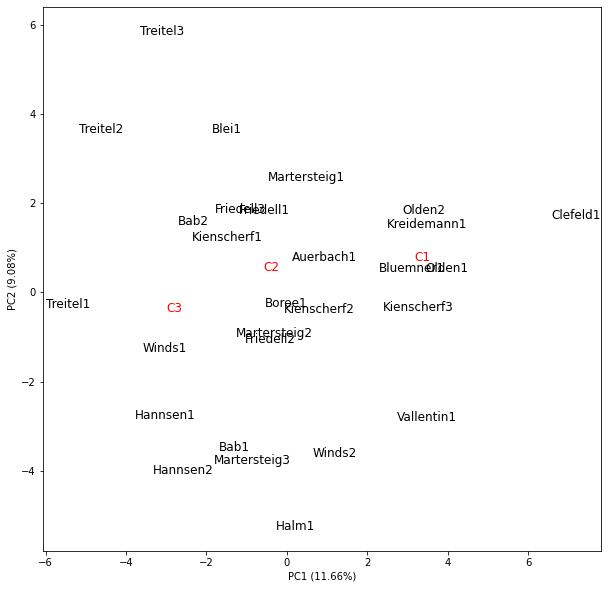

In [50]:
plot_pca(documents_proj, var_exp, list(authors_pca_hac) + list(clown_titles_pca_hac))

**Interpretation**

PCA erweist sich als ziemlich erfolglos für die untersuchten Texte. Während zwar viele Textchunks grundsätzlich miteinander clustern, können auch Textchunks derselben Autoren weit voneinander entfernt stehen. Auch die Texte des Clowns weisen keine besonders große Nähe zueinander auf. Das Scatterplot ist schwer zu interpretieren, für den Urheber der "Clown"-Texte gibt es keinen Aufschluss.

### 3.3.3 Durchführen der HAC

Das Ziel des hierarchical agglomerative clustering ist es, Datenpunkte aufgrund großer Ähnlichkeiten zusammenzufassen. Während zu Beginn jeder Datenpunkt als einzelner Cluster betrachtet wird, werden diese Datenpunkte schrittweise zu Clustern zusammengefasst, bis am Ende alle Datenpunkte ein Cluster bilden. Dieser Prozess kann in einem Dendogramm (Baumdiagramm) abgebildet werden (Gadakari 2019). Die Zusammenfassung der Datenpunkte zu Clustern geschieht durch Berechnung eines Ähnlichkeitsmaßes (linkage), das auf verschiedene Arten berechnet werden kann („single“ = minimaler Abstand aller Elementpaare aus den beiden Clustern; „complete“ = maximaler Abstand aller Elementpaare aus beiden Clustern, „average“ = Durchschnitt aller Punkte). Im Folgenden werden zuerst die Distanzen zwischen allen Dokumenten („Clown“-Dokumente und Referenztexte wurden hierfür zusammengefasst) berechnet, danach wird mit der Einstellung der Berechnungsweise daraus das Linkage-Objekt erstellt, durch das dann Dendrogramm erzeugt wird. 

In [51]:
# Preprocessing mit Anpassen der Vokabulargröße
s_reference_hac, s_clown_hac = preprocess_corpus(documents_pca_hac, clown_pca_hac, vocab_100)
all_documents = np.vstack((s_reference_hac, s_clown_hac))
all_documents = preprocessing.scale(np.vstack((s_reference_hac, s_clown_hac)))

In [52]:
# Berechnung der Distanzen
dm = scidist.pdist(all_documents, 'cosine')

# Erstellen des Dendrogramms
linkage_object = hierarchy.linkage(dm, method='average')

In [53]:
# Funktion zur Darstellung des Dendrogramms

def plot_tree_h(linkage_object, labels, figsize=(10, 5), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, 
            labels=labels, 
            ax=ax,
            link_color_func=lambda c: 'black',
            leaf_font_size=10, 
            leaf_rotation=0,
            orientation='left')                 # horizontal
            
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

    ylabels = ax.get_ymajorticklabels()
    for label in ylabels:                           # ylabels mit rot highlighten
        if label.get_text() in clown_titles_pca_hac:
            label.set_color('red')

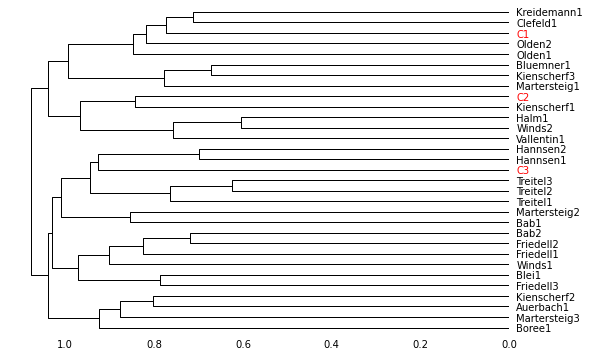

In [54]:
plot_tree_h(linkage_object, authors_pca_hac + clown_titles_pca_hac, figsize=(9, 6))

**Interpretation**

Auch hier clustern nicht einmal die Texte des "Clowns" mit sich selbst, Ähnlichkeiten der Textchunks der Autorenkandidaten sind durchaus zu beobachten (z.B. Friedell, Hannsen, Olden), gleichzeitig weisen die Texte der laut Delta wahrscheinlichsten Kandidaten Martersteig und Kienscherf auch mit sich selbst keine große Ähnlichkeit auf. Genau wie die PCA bleibt auch das Ergebnis der HAC schwer zu interpretieren. 

# 4. Diskussion

Ein eindeutiges Ergebnis, wer hinter dem Pseudonym „von einem Clown“ im Zeitraum von 1908 bis 1910 drei Texte für die Theaterzeitschrift *Die Schaubühne* verfasst hat, hat diese Untersuchung nicht ergeben. Während sich PCA und HAC als Methoden für dieses Korpus als völlig ungeeignet erwiesen und teilweise nicht einmal Ähnlichkeiten zwischen den Texten des unbekannten Autors selbst feststellen konnten (dass es sich beim Autor hinter allen „Clown“-Texten um ein und dieselbe Person handelt, ist immerhin relativ sicher, einerseits aufgrund der für eine\*n menschliche\*n Leser\*in erkennbaren stilistischen Gemeinsamkeiten, andererseits aber auch, weil der Autor in der ersten Person Singular z.B. in „Theatertrust“ auf den früheren Text „Menschenhandel“ mit „wie ich bereits in einer früheren Schrift ausführlich nachgewiesen habe“ verweist), konnte mit Burrows Delta zumindest ein starker Verdacht ermittelt werden. Burrows Delta erwies sich dabei auch nur mit Tokens als zielführend, nicht aber mit Zeichen-N-Grammen, mit welchen keine eindeutigen und nicht interpretierbare Ergebnisse ermittelt wurden. 

Burrows Delta mit Tokens lässt Otto Johannes Kienscherf (7. April 1868 Magdeburg bis 11. Januar 1957 Hannover), Schauspieler, Regisseur und Dramaturg, als „Clown“ vermuten. Biographisch ist Kienscherf auf jeden Fall als „Clown“ denkbar. Neben dem Theater schrieb er Artikel für Tageszeitungen. Darüber hinaus beteiligte sich an der Ausbildung des Schauspielernachwuchses und setzte sich als Obmann der Genossenschaft Deutscher Bühnenangehöriger für die Verbesserung der sozialen Absicherung und eine Erhöhung der Tarifverträge für Schauspieler\*innen ein (Gilbert 2015). Vom „Clown“ gibt es drei Texte in der *Schaubühne*: „Moderne Sklaven“ über die sklavenhaften, prekären Arbeitsbedingungen für Schauspieler\*innen; „Menschenhandel“ direkt in der Me-Too-Debatte, das davon handelt, wie eine junge Schauspielerin von einem Theaterdirektor nach einem Besuch in dessen Zimmer engagiert wird; und Theatertrust über die schlechte Bezahlung von Schauspieler*innen. 

Problematisch bei den „Clown“-Texten, was eventuell zu den uneindeutigen Ergebnissen führt, sind außerdem die Unterschiede im Genre. „Theatertrust“ und „Moderne Sklaven“ sind relativ sachlich verfasst und der Autor beschreibt hier vor allem Fakten und seine Sichtweise, während „Menschenhandel“ in Form einer Geschichte, mit direkten Reden, verfasst ist und damit die Ergebnisse vielleicht schwerer interpretierbar macht. Darüber hinaus ist das Problem nicht außer Acht zu lassen, dass der richtige Autor der Texte vielleicht von Beginn an nicht berücksichtigt wurde, da er entweder nie für die *Schaubühne* unter Klarnamen geschrieben hat, manuell bereits zu früh aussortiert wurde, weil er aufgrund anderer Genres oder ganz anderer Themen als zu unplausibel erschienen ist, oder außer mit N-Grammen nicht weiter berücksichtigt wurde, weil zu wenig Tokens zu finden waren.

Da jedoch sowohl der biographische Hintergrund als auch Delta mit Tokens so stark auf Otto Kienscherf hindeuten, soll zumindest für das Projekt im Rahmen dieses Seminars **Otto Kienscherf** als „Clown“ betrachtet werden. 


## Quellen


- Auerbach, Alfred: Vor- und Frühgeschichte des Gebiets von Ostthüringen zwischen Elster und Sahle, in: Geschichte der Stadt Weide in Einzeldarstellungen. 1 Band, 2, Heft, Thomas & Hubert, Weida 1927. 
- Austrian Academy of Sciences / Austrian Centre for Digital Humanities and Cultural Heritage: [Siegfried Jacobsohn: "Die Schaubühne"](https://www.oeaw.ac.at/de/acdh/projects/die-schaubuehne-siegfried-jacobsohn), 2022. 
- Blei, Franz: Erdachte Geschehnisse. Zehn Studien. Georg Müller, München und Leipzig, 1911.
- Evert, Stefan et al.: Understanding and explaining Delta measures for authorship attribution, in: Digital Scholarship in the Humanities, 2017, Vol. 32, Supplement 2, S. 5-16. 
- Gadakari, Mahesh: [Hierarchical Agglomerative Clustering (HAC) with Single linkage method]( https://medium.com/@MaheshGadakari/hierarchical-agglomerative-clustering-hac-with-single-linkage-method-1159fa623d52), 2019. 
- Jacobsohn, Siegfried: Die Schaubühne (Bände 3.1 bis 8.2), 1906 bis 1913. 
- Kestemont, Mike et al: Collaborative authorship in the twelfth century: A stylometric study of Hildegard of Bingen and Guibert of Gembloux, in: Digital Scholarship in the Humanities, 2015, Vol. 30, No. 2, S. 199-224. 
- Kienscherf , Otto Johannes:  Schaubühne und Publikum, in: [Badisches Landestheater Karlsruhe. Almanach 1930](https://digital.blb-karlsruhe.de/blbihd/theaterzettel/periodical/titleinfo/1160900), hrsg. von Otto Kienscherf und Walther Landgrebe, Karlsruhe 1930, S. 34-38.
- Gilbert, René: [Otto Johannes Kienscherf](https://stadtlexikon.karlsruhe.de/index.php/De:Lexikon:bio-0372), in: Stadtlexikon Karlsruhe, 2015. 
- Kienscherf , Otto Johannes: [Die Schaubühne der Zukunft](https://digi.ub.uni-heidelberg.de/diglit/suedwestdeutsche_rundschau1902/0315/image,info), in: Südwestdeutsche Rundschau. Halbmonatsschrift für deutsche Art und Kunst, Frankfurt a.M. 1902, Heft 8, S. 281-286.
- Kienscherf , Otto Johannes: Scham wider Kunst, in: [Badisches Landestheater Karlsruhe. Almanach 1926/27](https://digital.blb-karlsruhe.de/blbihd/theaterzettel/periodical/titleinfo/1160900), hrsg. im Auftrag der Generaldirektion des Badischen Landestheaters von Werner Hugo Kaufmann, München 1926/27, S. 116-124. 
- Kienscherf , Otto Johannes: Vom künstlerischen Problem des Schauspielers, in: [Badisches Landestheater Karlsruhe. Almanach 1929]( https://digital.blb-karlsruhe.de/blbihd/theaterzettel/periodical/titleinfo/1160900), hrsg. vom Verlag Theaterkunst – Otto Glenk, München 1929, S. 45-58.
- Martersteig, Max: Der Schauspieler. Ein künstlerisches Problem. Eine Studie. Eugen Diedrichs, Leipzig 1900.
- Martersteig, Max: Die Bühne der Neuzeit, in: Das deutsche Theater im neunzehnten Jahrhundert. Eine kulturgeschichtliche Darstellung, Breitkopf & Härtel, Leipzig 1924. 
- Martersteig, Max: Die ethische Aufgabe der Schaubühne. Eine Schillerrede, Insel-Verlag, Leipzig 1912. 
